### Local Variance Estimation

When working with time series (observations of a natural sequential ordering) one often wishes to estimate the variance of the time series locally. This notebook will go over a collection of methods that can be utilized to create an estimator for the local variance (or volatility) function

In [1]:

import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../")


PATH = "../../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)
DATA_FILE = "AMZN_reconstructed_features.csv"


In [2]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0, nrows=10000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]


In [3]:

regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

,Date,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,...,YearMonth,Imbalance,MOX_Identifier,Effective_Spread,Microprice,Imbalance_Weighted_Effective_Spread,Price_Impact,Realized_Spread,Midprice,Trade_Side
index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00.820,2020-01-02,D,AMZN,100.0,1874.5450,@,N,0.0,21402,140.0,...,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24389,191.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24286,185.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.040,2020-01-02,D,AMZN,100.0,1874.7400,@,N,0.0,24778,233.0,...,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.160,2020-01-02,D,AMZN,200.0,1874.9900,@,N,0.0,26914,252.0,...,NaN,NaN,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


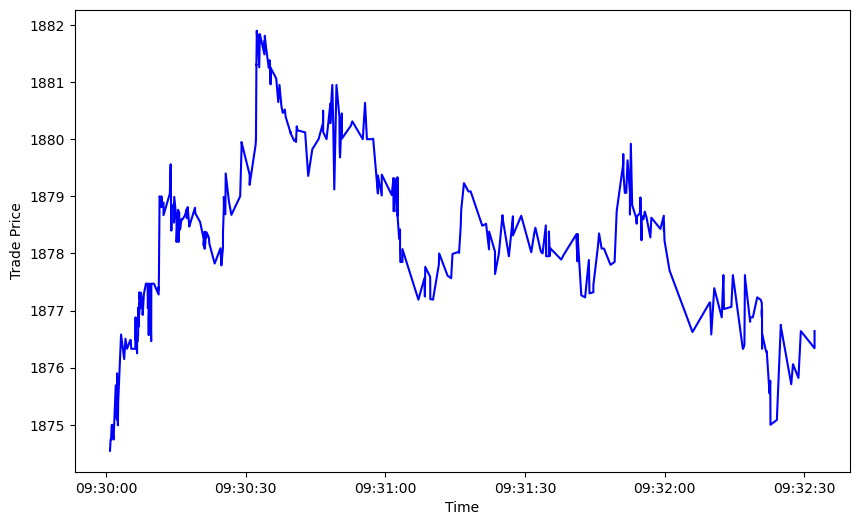

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(regular_trades.index, regular_trades["Trade_Price"], color="blue", label="Trade Price")

ax.set_xlabel("Time")
ax.set_ylabel("Trade Price")

plt.show()


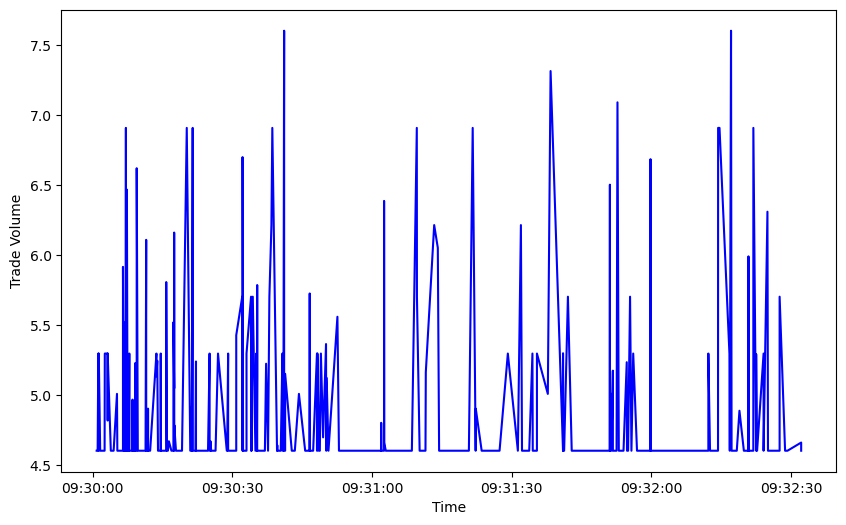

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(regular_trades.index, np.log(regular_trades["Trade_Volume"]), color="blue", label="Trade Volume")

ax.set_xlabel("Time")
ax.set_ylabel("Trade Volume")

plt.show()


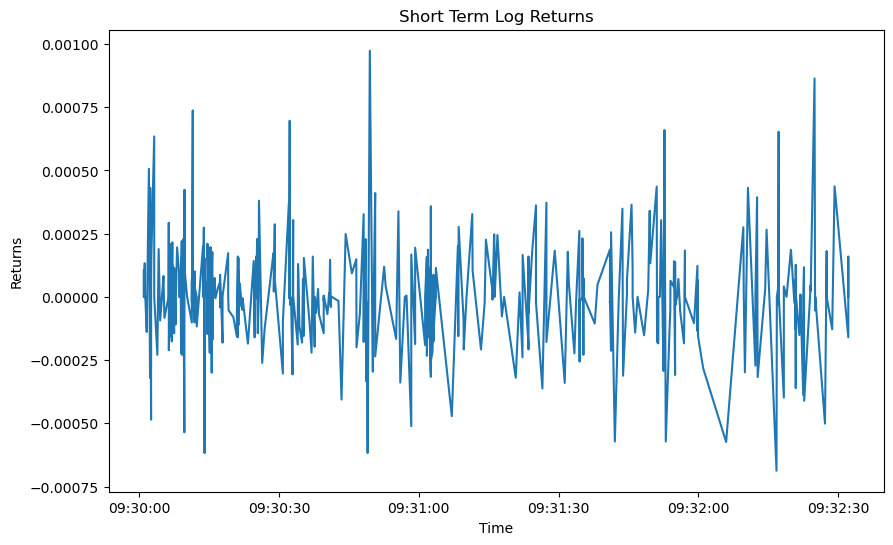

In [6]:
returns= np.log(regular_trades["Trade_Price"][1:].values/regular_trades["Trade_Price"][:-1].values)

returns=pd.Series(returns, index=regular_trades.index[1:])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(returns)
ax.set_title("Short Term Log Returns")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
plt.show()


### Local Variance Estimators

Assuming that $E[r_t] = 0$ for all $t$, the local variance of a time series $r_t$ is defined as

$$\sigma^2_t = \frac{1}{T}\sum_{i=1}^T r_i^2$$

where $T$ is the window size. This is the most basic estimator of the local variance, and is often referred to as the "naive" estimator. It is also known as the "sample variance" estimator. The sample variance estimator is unbiased, but has high variance. This is because the variance of the sample mean is proportional to $1/T$, and the variance of the sample variance is proportional to $1/T^2$. This means that the variance of the sample variance is proportional to $1/T$, which is why the sample variance estimator has high variance.

In [7]:
def sample_variance(returns, T):

    def compute_sample_variance(x):
        return (x**2).sum() / (T )
    return returns.rolling(T).apply(lambda x: compute_sample_variance(x))

In [30]:
naive_variance = sample_variance(returns, 25).dropna()

padded_variance=np.pad(naive_variance, (25,0),mode='mean')/naive_variance[0]




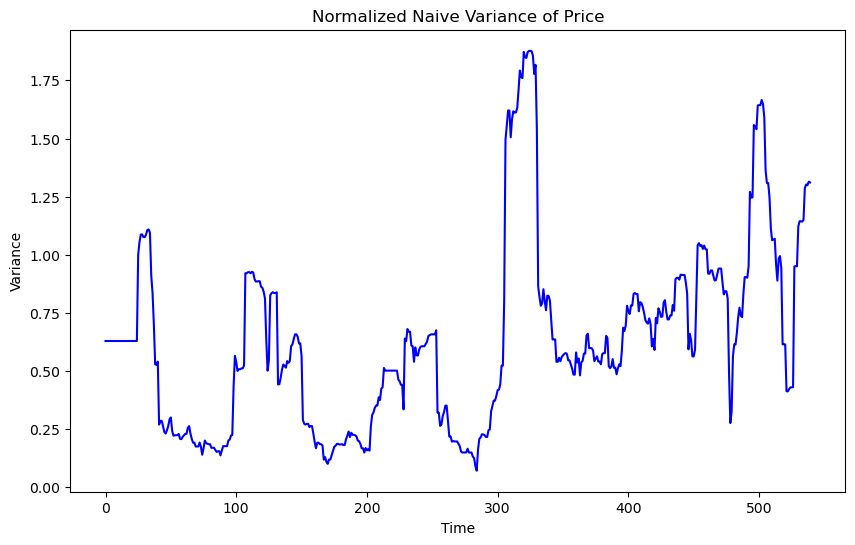

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(padded_variance, color="blue", label="Naive Variance")
ax.set_title("Normalized Naive Variance of Price")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
plt.show()


### Regression Trees

Decision Trees / Regression Trees are great models for generating piecewise constant estimates. They are also very easy to implement. The downside is that they are not very flexible, and can only generate piecewise constant estimates. This is a problem because the local variance is not piecewise constant. However, we can use the regression tree to generate a coarse estimate of the local variance, and then use this as an adaptive filter when trend filtering the time series.

In [33]:
from sklearn import tree


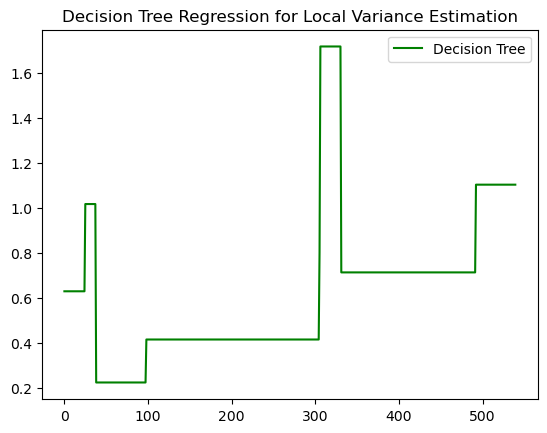

In [36]:
model=tree.DecisionTreeRegressor(max_depth=3)

model.fit(np.arange(len(padded_variance)).reshape(-1,1),  padded_variance)

predictions=model.predict(np.arange(len( padded_variance)).reshape(-1,1))

plt.title("Decision Tree Regression for Local Variance Estimation")

plt.plot(np.arange(len( padded_variance)), predictions, color="green", label="Decision Tree")

plt.legend()

### Effect of Volume Variance on Trend Filtering

In [37]:
import sys
sys.path.append("../")
from estimators.trend_filtering.trend_filter import Trend_Filter
from estimators.cv_base_estimator import cv_base_estimator

from estimators.regression.piecewise_polynomial import Piecewise_Polynomial_Model

In [38]:
trade_price=regular_trades["Trade_Price"].values

x=np.arange(len(trade_price))

tf=Trend_Filter(x,trade_price,k=1)

start_time = time.time()
cv_base_estimator(tf)

print("--- %s seconds ---" % (time.time() - start_time))


Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 1.8596197329909214
Performing cross validation for lambda = 3.5903635950720467
Performing cross validation for lambda = 6.9319068388707
Performing cross validation for lambda = 13.383416790637941
Performing cross validation for lambda = 25.83933240238262
Performing cross validation for lambda = 49.88794038513949
Performing cross validation for lambda = 96.31853320025186
Performing cross validation for lambda = 185.96197329909214
Performing cross validation for lambda = 359.0363595072047
Performing cross validation for lambda = 693.19068388707
Performing cross validation for lambda = 1338.3416790637928
Performing cross validation for lambda = 2583.933240238262
Performing cross validation for lambda = 4988.794038513949
Performing cross validation for lambda = 9631.853320025175
Performing cross validation for lambda = 18596.197329909213
Performing  1 out of 3 iterations of cross validation
Perfo

In [39]:
regime_model=Piecewise_Polynomial_Model(x,tf.y_hat,k=1,method="continous_tf")

[ 39 123 187 192 240 302 363 452]
{1: [240], 2: [187, 240], 3: [240, 363, 452], 4: [187, 240, 363, 452], 5: [123, 192, 240, 363, 452], 6: [123, 192, 240, 302, 363, 452], 7: [39, 123, 192, 240, 302, 363, 452], 8: [39, 123, 187, 192, 240, 302, 363, 452], 0: []}
k: 0 mse: 1.8435723963096575
k: 1 mse: 0.32340879570245346
k: 2 mse: 0.2852344161118631
k: 3 mse: 0.11807079281730613
k: 4 mse: 0.07989641322671581
k: 5 mse: 0.011884477392067947
k: 6 mse: 0.004667938919476261
k: 7 mse: 0.00031653575610003903
k: 8 mse: 0.0004694940998985838


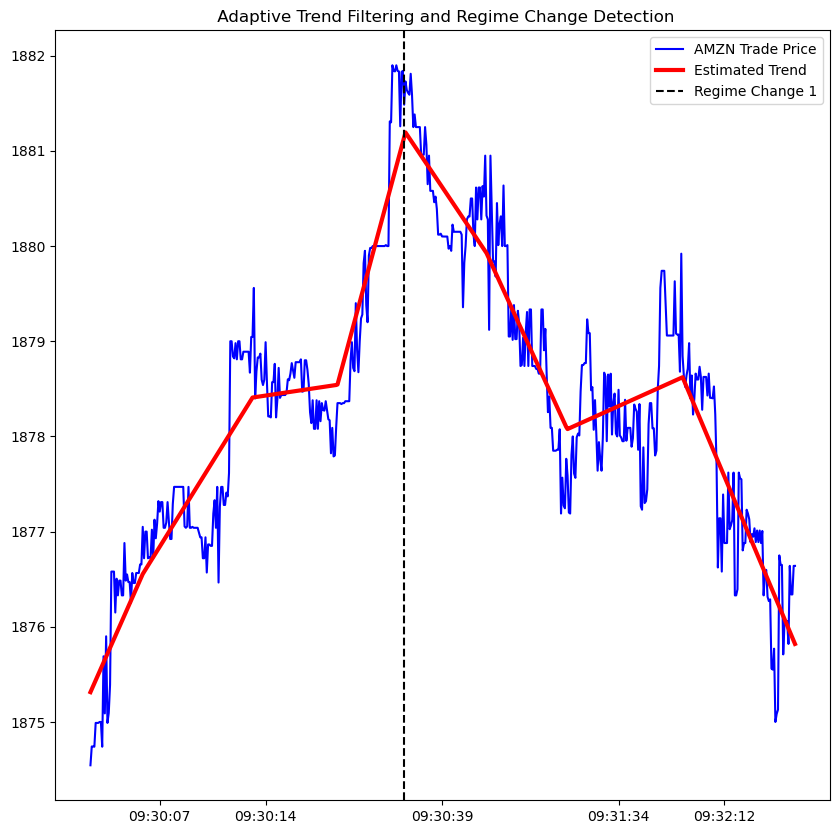

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(tf.y_hat, label="Estimated Trend ",color='red',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

### Adaptive Trend Filtering

Here we pass in the reciprocal of the local variance as a weight to the trend filter. This is a very simple way to adaptively filter the time series. The intuition is that if the local variance is high, then the time series is more volatile, and we should be more conservative in our trend filtering. If the local variance is low, then the time series is less volatile, and we can be more aggressive in our trend filtering.

In [41]:
atf=Trend_Filter(x,trade_price,k=1,method="primal_dual",prior=1/predictions)

start_time = time.time()
cv_base_estimator(atf)

print("--- %s seconds ---" % (time.time() - start_time))

Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 1.8491379477737173
Performing cross validation for lambda = 3.570126436158549
Performing cross validation for lambda = 6.89283500211736
Performing cross validation for lambda = 13.30798088415497
Performing cross validation for lambda = 25.6936884690597
Performing cross validation for lambda = 49.6067459738473
Performing cross validation for lambda = 95.77563178899538
Performing cross validation for lambda = 184.91379477737175
Performing cross validation for lambda = 357.01264361585487
Performing cross validation for lambda = 689.283500211736
Performing cross validation for lambda = 1330.7980884154956
Performing cross validation for lambda = 2569.3688469059703
Performing cross validation for lambda = 4960.674597384731
Performing cross validation for lambda = 9577.563178899527
Performing cross validation for lambda = 18491.379477737173
Performing  1 out of 3 iterations of cross validation
Perfo

In [42]:
regime_model=Piecewise_Polynomial_Model(x,atf.y_hat,k=1,method="continous_tf")

regime_model.knots

[ 25  98 116 195 238 272 362 379 423 439 509 523]
{1: [238], 2: [238, 439], 3: [238, 423, 439], 4: [116, 195, 238, 439], 5: [116, 195, 238, 423, 439], 6: [25, 116, 195, 238, 423, 439], 7: [25, 116, 195, 238, 379, 423, 439], 8: [25, 98, 116, 195, 238, 379, 423, 439], 9: [25, 98, 116, 195, 238, 379, 423, 439, 523], 10: [25, 98, 116, 195, 238, 362, 379, 423, 439, 523], 11: [25, 98, 116, 195, 238, 362, 379, 423, 439, 509, 523], 12: [25, 98, 116, 195, 238, 272, 362, 379, 423, 439, 509, 523], 0: []}
k: 0 mse: 2.033431867240091
k: 1 mse: 0.6639443206619695
k: 2 mse: 0.5644418330067728
k: 3 mse: 0.48448941253199157
k: 4 mse: 0.394035227061592
k: 5 mse: 0.31408280658681076
k: 6 mse: 0.24929759771688695
k: 7 mse: 0.19239699696106177
k: 8 mse: 0.13752021780938925
k: 9 mse: 0.11021484124631578
k: 10 mse: 0.10443261464901211
k: 11 mse: 0.10468250202000974
k: 12 mse: 0.11324489374284062


[238]

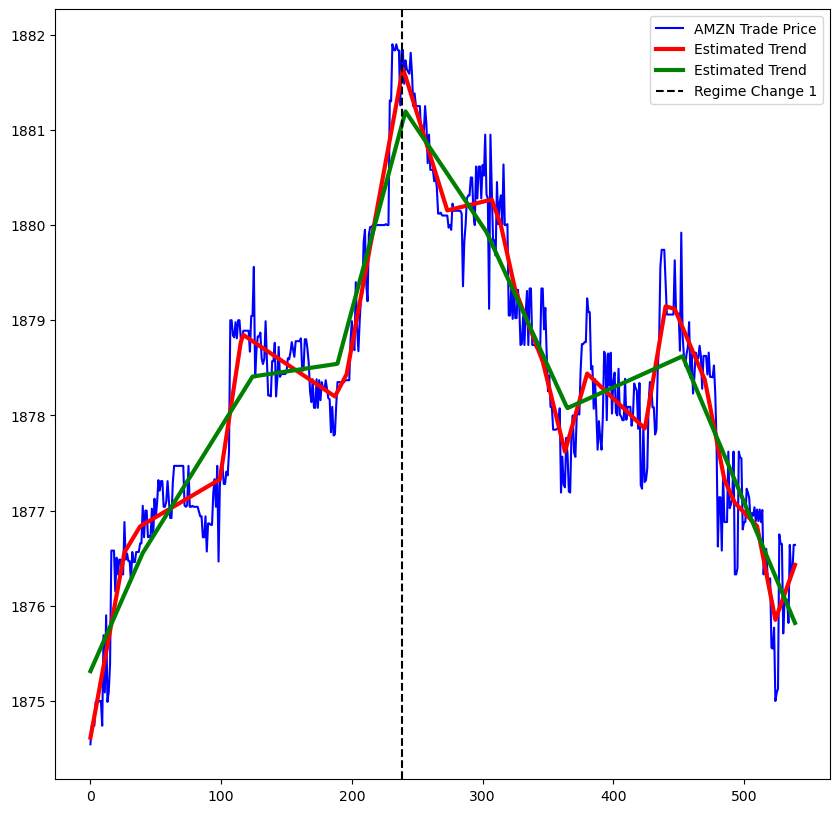

In [43]:
fig,    ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(atf.y_hat, label="Estimated Trend ",color='red',lw=3)
ax.plot(tf.y_hat, label="Estimated Trend ",color='green',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()


### Adaptive Trend Filtering with Volume



Text(0, 0.5, 'Log of Trade Volume')

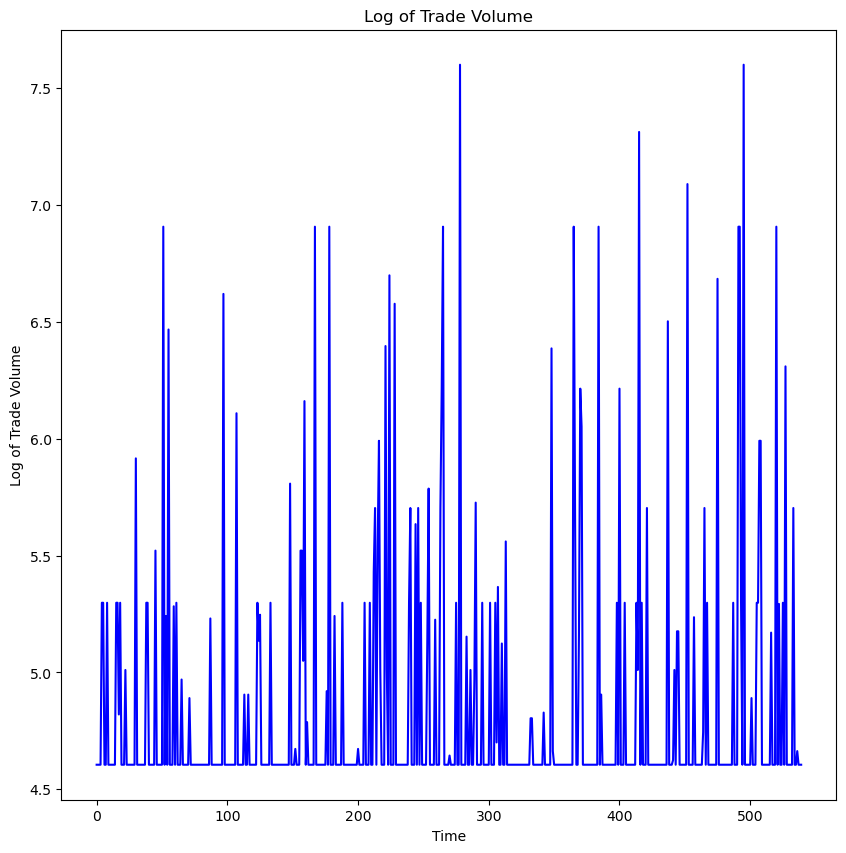

In [56]:
volume=np.log(regular_trades["Trade_Volume"].values)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(volume, label="AMZN Trade Volume",color='blue')
ax.set_title("Log of Trade Volume")
ax.set_xlabel("Time")
ax.set_ylabel("Log of Trade Volume")


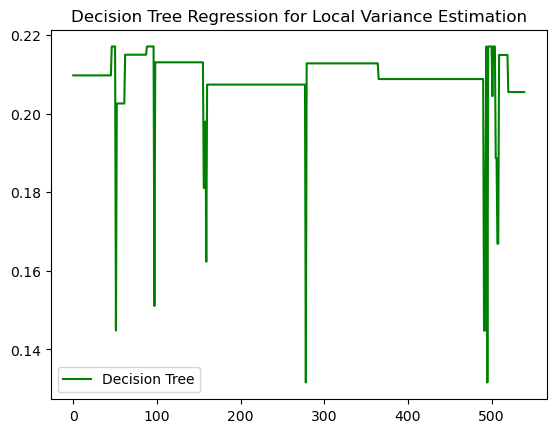

In [55]:
vol_tree=tree.DecisionTreeRegressor(max_depth=5)

vol_tree.fit(np.arange(len(volume)).reshape(-1,1),  volume)

predictions=vol_tree.predict(np.arange(len( volume)).reshape(-1,1))

plt.title("Decision Tree Regression for Local Variance Estimation")

plt.plot(np.arange(len( volume)), predictions, color="green", label="Decision Tree")

plt.legend()


In [51]:
vtf=Trend_Filter(x,trade_price,k=1,method="primal_dual",prior=1/predictions)

start_time = time.time()
cv_base_estimator(vtf)

print("--- %s seconds ---" % (time.time() - start_time))



Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 1.7288472302575
Performing cross validation for lambda = 3.3378814210442513
Performing cross validation for lambda = 6.44444007889173
Performing cross validation for lambda = 12.442265824240467
Performing cross validation for lambda = 24.02225436902274
Performing cross validation for lambda = 46.37971195292793
Performing cross validation for lambda = 89.54520453377735
Performing cross validation for lambda = 172.88472302575
Performing cross validation for lambda = 333.78814210442516
Performing cross validation for lambda = 644.444007889173
Performing cross validation for lambda = 1244.2265824240453
Performing cross validation for lambda = 2402.2254369022744
Performing cross validation for lambda = 4637.971195292793
Performing cross validation for lambda = 8954.520453377725
Performing cross validation for lambda = 17288.472302575
Performing  1 out of 3 iterations of cross validation
Performing

In [52]:
regime_model=Piecewise_Polynomial_Model(x,vtf.y_hat,k=1,method="continous_tf")


[ 97 112 224 365 379 424 438 472 508 523]
{1: [224], 2: [224, 438], 3: [224, 424, 438], 4: [224, 424, 438, 523], 5: [224, 379, 424, 438, 523], 6: [224, 365, 379, 424, 438, 523], 7: [224, 365, 379, 424, 438, 508, 523], 8: [224, 365, 379, 424, 438, 472, 508, 523], 9: [97, 112, 224, 365, 379, 424, 438, 508, 523], 10: [97, 112, 224, 365, 379, 424, 438, 472, 508, 523], 0: []}
k: 0 mse: 2.092057227648558
k: 1 mse: 0.6914340000286716
k: 2 mse: 0.6109982130279966
k: 3 mse: 0.5505575253838954
k: 4 mse: 0.5201307887600711
k: 5 mse: 0.5009027722832022
k: 6 mse: 0.49888398383114824
k: 7 mse: 0.4987927436777416
k: 8 mse: 0.5122946910774303
k: 9 mse: 0.6100481757712157
k: 10 mse: 0.6235501231709043


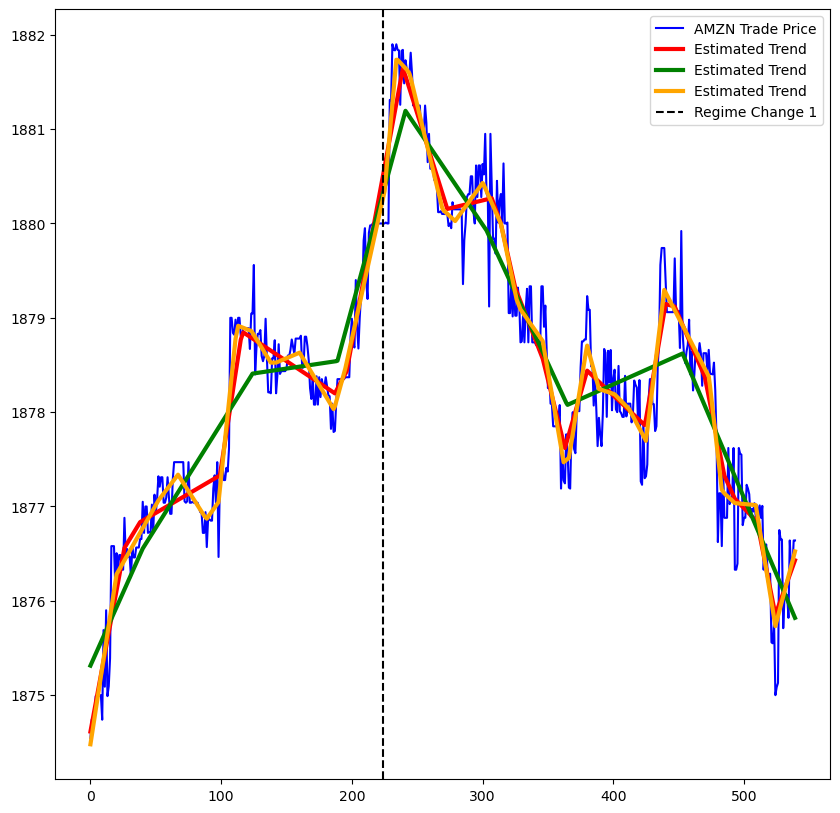

In [53]:
fig,    ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(atf.y_hat, label="Estimated Trend ",color='red',lw=3)
ax.plot(tf.y_hat, label="Estimated Trend ",color='green',lw=3)
ax.plot(vtf.y_hat, label="Estimated Trend ",color='orange',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()